In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, GridSearchCV
import time

In [2]:
d = np.load("../data/training_data/splits.npz", allow_pickle=True)
X_train = d["X_train"]
X_test = d["X_test"]
y_train = d["y_train"]
y_test = d["y_test"]

In [3]:
# Test different kernel functions
kernels = ['linear', 'rbf', 'poly', 'sigmoid']
kernel_results = {}

for kernel in kernels:
    print(f"\nTraining SVC with {kernel} kernel...")

    # Initialize SVC with specific kernel
    svc = SVC(kernel=kernel, random_state=42)

    # Train and time
    start_time = time.time()
    svc.fit(X_train, y_train)
    training_time = time.time() - start_time

    # Predict and evaluate
    y_pred = svc.predict(X_test)
    svc_accuracy = accuracy_score(y_test, y_pred)

    kernel_results[kernel] = {
        'accuracy': svc_accuracy,
        'training_time': training_time
    }

    print(f"  Accuracy: {svc_accuracy:.4f}")
    print(f"  Training time: {training_time:.2f} seconds")

# Display kernel comparison
print("\nKERNEL COMPARISON")
for kernel, results in kernel_results.items():
    print(f"{kernel:8} -> Accuracy: {results['accuracy']:.4f}, Time: {results['training_time']:.2f}s")


Training SVC with linear kernel...
  Accuracy: 0.4531
  Training time: 1.55 seconds

Training SVC with rbf kernel...
  Accuracy: 0.7550
  Training time: 0.32 seconds

Training SVC with poly kernel...
  Accuracy: 0.3700
  Training time: 3.97 seconds

Training SVC with sigmoid kernel...
  Accuracy: 0.3425
  Training time: 0.90 seconds

KERNEL COMPARISON
linear   -> Accuracy: 0.4531, Time: 1.55s
rbf      -> Accuracy: 0.7550, Time: 0.32s
poly     -> Accuracy: 0.3700, Time: 3.97s
sigmoid  -> Accuracy: 0.3425, Time: 0.90s


In [11]:
# Define parameter grid for tuning
param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'gamma': ['scale', 'auto', 0.1, 0.01, 0.001],  # Kernel coefficient
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid']  # Most common kernels
}

print("Starting Grid Search for SVC...")
start_time = time.time()

# Perform grid search with cross-validation
grid_search = GridSearchCV(
    SVC(
        random_state=42, 
        probability=True,
    ),
    param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='accuracy',
    n_jobs=-1,  # Use all available cores
    verbose=1
)

grid_search.fit(X_train, y_train)

print(f"Grid search completed in {time.time() - start_time:.2f} seconds")

# Best parameters and score
print("\nBest parameters found:")
print(grid_search.best_params_)
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

Starting Grid Search for SVC...
Fitting 5 folds for each of 80 candidates, totalling 400 fits
Grid search completed in 1881.69 seconds

Best parameters found:
{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}
Best cross-validation score: 0.9077


In [17]:
# Create a DataFrame from cv_results_
results = pd.DataFrame(grid_search.cv_results_)

# Columns to keep
keep = [
    "params",
    "mean_test_score",
    "std_test_score",
    "rank_test_score",
    "mean_fit_time",
    "mean_score_time",
    "std_fit_time"
]
df = results[keep].copy()

# Display top 10 parameter combinations by mean test score
df_sorted = df.sort_values("mean_test_score", ascending=False).reset_index(drop=True)
print("SVC Top 10 parameter combinations by CV accuracy:")
df_sorted.head(10)

SVC Top 10 parameter combinations by CV accuracy:


,params,mean_test_score,std_test_score,rank_test_score,mean_fit_time,mean_score_time,std_fit_time
0,"{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}",0.907656,0.002856,1,2.423790,0.122878,0.090610
1,"{'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}",0.887969,0.005625,2,2.848537,0.147068,0.044063
2,"{'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}",0.887656,0.005285,3,2.614001,0.140629,0.166516
3,"{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}",0.855781,0.008158,4,2.433111,0.178532,0.220086
4,"{'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}",0.818906,0.009825,5,2.694994,0.194156,0.242515
5,"{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}",0.818750,0.011037,6,2.516189,0.184527,0.056436
6,"{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}",0.768750,0.008089,7,3.380806,0.210752,0.061476
7,"{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}",0.764844,0.013286,8,2.938956,0.220909,0.078751
8,"{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}",0.740000,0.009650,9,3.239660,0.236326,0.088786
9,"{'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}",0.739375,0.009011,10,3.694860,0.254991,0.410781


In [18]:
# Train final model with best parameters
final_svc = grid_search.best_estimator_

# Make final predictions
y_pred_final = final_svc.predict(X_test)

# Comprehensive evaluation
final_accuracy = accuracy_score(y_test, y_pred_final)
print(f"\nFinal SVC Model Performance:")
print(f"Test Accuracy: {final_accuracy:.4f}")
print(f"Best Parameters: {grid_search.best_params_}")
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred_final))


Final SVC Model Performance:
Test Accuracy: 0.9081
Best Parameters: {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}

Detailed Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       425
           1       0.96      0.91      0.94       379
           2       0.81      0.92      0.86       397
           3       0.87      0.79      0.83       399

    accuracy                           0.91      1600
   macro avg       0.91      0.91      0.91      1600
weighted avg       0.91      0.91      0.91      1600



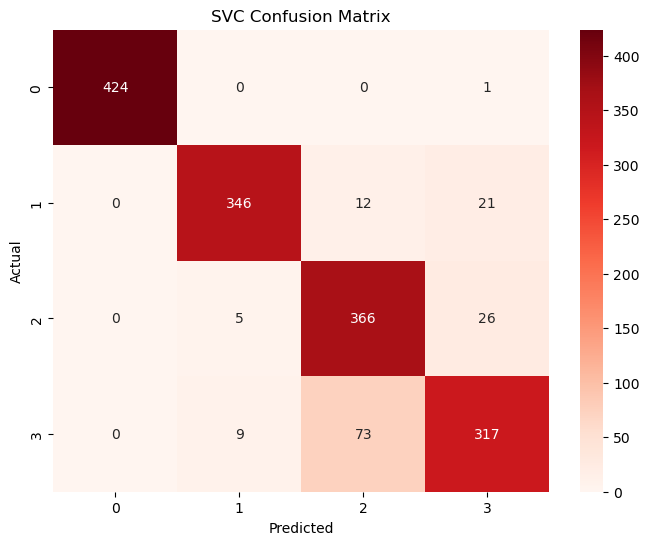

In [19]:
# Create confusion matrix
cm = confusion_matrix(y_test, y_pred_final)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds',
            xticklabels=np.unique(y_test),
            yticklabels=np.unique(y_test))
plt.title('SVC Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [20]:
# Perform cross-validation on the best model
cv_scores = cross_val_score(final_svc, X_train, y_train, cv=5, scoring='accuracy')

print("Cross-Validation Results:")
print(f"CV Scores: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

Cross-Validation Results:
CV Scores: [0.909375   0.903125   0.91171875 0.90703125 0.90703125]
Mean CV Accuracy: 0.9077 (+/- 0.0057)


C =   0.01: Accuracy = 0.5219
C =    0.1: Accuracy = 0.6569
C =      1: Accuracy = 0.7550
C =     10: Accuracy = 0.8294
C =    100: Accuracy = 0.8938
C =   1000: Accuracy = 0.9156


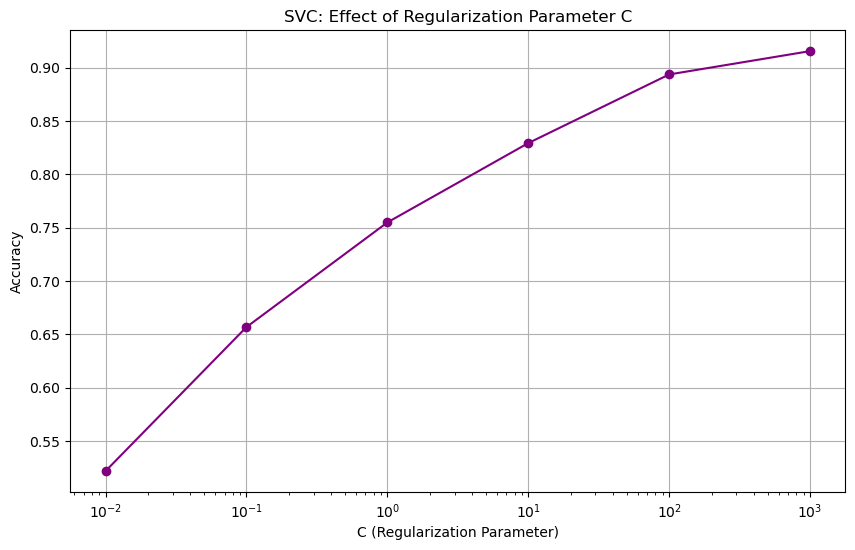

In [21]:
# Test different C values to understand regularization effect
C_values = [0.01, 0.1, 1, 10, 100, 1000]
C_results = []

for C_val in C_values:
    svc_temp = SVC(C=C_val, kernel='rbf', gamma='scale', random_state=42)
    svc_temp.fit(X_train, y_train)
    y_pred_temp = svc_temp.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred_temp)
    C_results.append(accuracy)
    print(f"C = {C_val:6}: Accuracy = {accuracy:.4f}")

# Plot C vs Accuracy
plt.figure(figsize=(10, 6))
plt.semilogx(C_values, C_results, marker='o', linestyle='-', color='purple')
plt.xlabel('C (Regularization Parameter)')
plt.ylabel('Accuracy')
plt.title('SVC: Effect of Regularization Parameter C')
plt.grid(True)
plt.show()

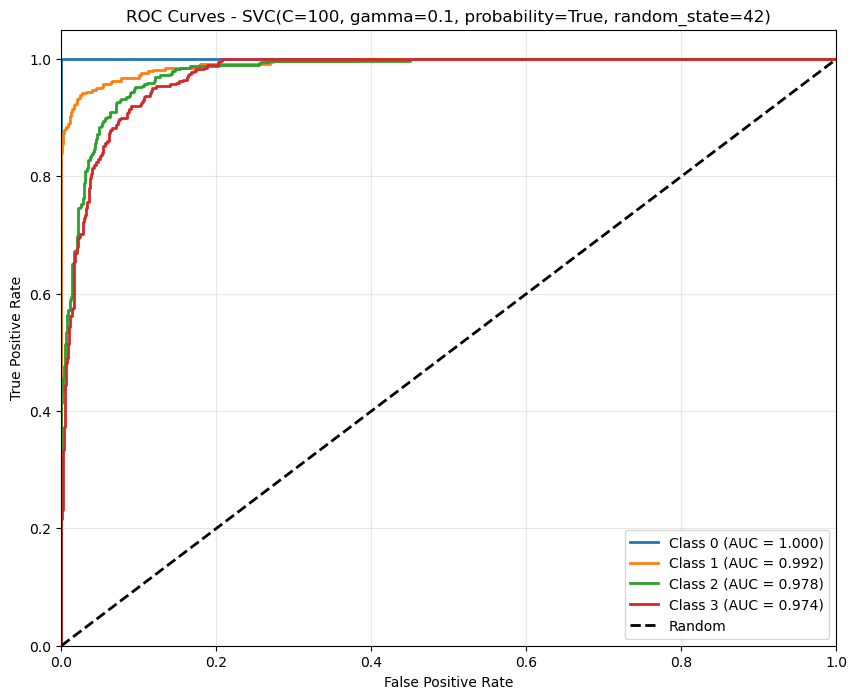

In [22]:
# Get predictions for all classes
y_pred_proba = final_svc.predict_proba(X_test)

# Binarize the labels (convert to one-hot encoding)
n_classes = len(np.unique(y_test))
y_test_bin = label_binarize(y_test, classes=range(n_classes))

# Calculate ROC curve for each class
plt.figure(figsize=(10, 8))

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {i} (AUC = {roc_auc:.3f})')

# Add random classifier line and format
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curves - {final_svc}')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

In [23]:
# Save the classification report
report_dict = classification_report(y_test, y_pred_final, output_dict=True)
df = pd.DataFrame(report_dict).transpose()
df.to_csv("performance_metrics/classification_reports/svc_report.csv") 

In [24]:
import joblib
# Save the trained model
joblib.dump(final_svc, 'trained_models/svc_model.pkl')
print("SVC model saved")

SVC model saved
